<a href="https://colab.research.google.com/github/arpitsolanki/IPL-Prediction-Engine/blob/main/IPL_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import all the libraries
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

# Visualize it as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from plotly.subplots import make_subplots



from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.preprocessing import LabelEncoder#Label Encoder
from sklearn.preprocessing import OneHotEncoder#One Hot Encoder
from sklearn.metrics import confusion_matrix#Confusion Matrix
from sklearn.metrics import roc_curve#RoC Curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve#Metrics Functions



In [2]:
# All Matches
all_matches=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/IPL-Prediction-Engine/main/all_matches_new.csv')
team_mapping=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/IPL-Prediction-Engine/main/team_mapping.csv')
venue_mapping=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/IPL-Prediction-Engine/main/venue_mapping.csv')
team_mapping_new=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/IPL-Prediction-Engine/main/team_mapping_new.csv')


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
all_matches

all_matches['start_date']=pd.to_datetime(all_matches['start_date'])
all_matches.loc[all_matches['start_date']>='2021-04-30']

,match_id,season,start_date,venue,innings,ball,batting_team_id,bowling_team_id,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
193617,1254058,2021,2021-09-04,"MA Chidambaram Stadium, Chepauk, Chennai",1,0.1,9,14,RG Sharma,CA Lynn,Mohammed Siraj,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193618,1254058,2021,2021-09-04,"MA Chidambaram Stadium, Chepauk, Chennai",1,0.2,9,14,RG Sharma,CA Lynn,Mohammed Siraj,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193619,1254058,2021,2021-09-04,"MA Chidambaram Stadium, Chepauk, Chennai",1,0.3,9,14,RG Sharma,CA Lynn,Mohammed Siraj,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193620,1254058,2021,2021-09-04,"MA Chidambaram Stadium, Chepauk, Chennai",1,0.4,9,14,RG Sharma,CA Lynn,Mohammed Siraj,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193621,1254058,2021,2021-09-04,"MA Chidambaram Stadium, Chepauk, Chennai",1,0.5,9,14,RG Sharma,CA Lynn,Mohammed Siraj,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199917,1254083,2021,2021-04-30,"Narendra Modi Stadium, Ahmedabad",2,19.2,14,6,KA Jamieson,HV Patel,RP Meredith,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199918,1254083,2021,2021-04-30,"Narendra Modi Stadium, Ahmedabad",2,19.3,14,6,HV Patel,KA Jamieson,Mohammed Shami,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199919,1254083,2021,2021-04-30,"Narendra Modi Stadium, Ahmedabad",2,19.4,14,6,HV Patel,KA Jamieson,Mohammed Shami,0,0,NaN,NaN,NaN,NaN,NaN,caught,HV Patel,NaN,NaN
199920,1254083,2021,2021-04-30,"Narendra Modi Stadium, Ahmedabad",2,19.5,14,6,KA Jamieson,Mohammed Siraj,Mohammed Shami,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
all_matches.loc[all_matches['season']=='2020/21','season']='2020'
all_matches.loc[all_matches['season']=='2007/08','season']='2008'
all_matches.loc[all_matches['season']=='2009/10','season']='2009'

all_matches['season']=pd.to_numeric(all_matches['season'])

In [5]:
all_matches.season.unique()

array([2008, 2009, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2019, 2018,
       2020, 2021])

In [6]:
match_results=all_matches.groupby(['season','match_id','innings','batting_team_id','venue']).agg({'runs_off_bat':'sum','extras':'sum','player_dismissed':'count'}).reset_index()
match_results['total_runs']=match_results['runs_off_bat']+match_results['extras']
match_results=match_results[['season','match_id','innings','venue','batting_team_id','total_runs','player_dismissed']]
match_results=match_results.rename(columns={'player_dismissed':'wickets_fallen'})
match_results

,season,match_id,innings,venue,batting_team_id,total_runs,wickets_fallen
0,2008,335982,1,M Chinnaswamy Stadium,8,222,3
1,2008,335982,2,M Chinnaswamy Stadium,14,82,10
2,2008,335983,1,"Punjab Cricket Association Stadium, Mohali",1,240,5
3,2008,335983,2,"Punjab Cricket Association Stadium, Mohali",6,207,4
4,2008,335984,1,Feroz Shah Kotla,11,129,8
...,...,...,...,...,...,...,...
1707,2021,1254081,2,"Arun Jaitley Stadium, Delhi",9,172,3
1708,2021,1254082,1,"Narendra Modi Stadium, Ahmedabad",8,154,6
1709,2021,1254082,2,"Narendra Modi Stadium, Ahmedabad",3,156,3
1710,2021,1254083,1,"Narendra Modi Stadium, Ahmedabad",6,179,5


In [7]:
# res_a=match_results.drop_duplicates(subset='match_id',keep='first')
# res_b=match_results.drop_duplicates(subset='match_id',keep='last')

res_a=match_results.loc[match_results['innings']==1]
res_b=match_results.loc[match_results['innings']==2]

res_combined=pd.merge(left=res_a,right=res_b,left_on=['match_id'],right_on=['match_id'],how='inner')

res_combined['winning_team']=0
res_combined['losing_team']=0

res_combined.loc[res_combined['total_runs_x']>res_combined['total_runs_y'],'winning_team']=res_combined.loc[res_combined['total_runs_x']>res_combined['total_runs_y'],'batting_team_id_x']
res_combined.loc[res_combined['total_runs_x']>res_combined['total_runs_y'],'losing_team']=res_combined.loc[res_combined['total_runs_x']>res_combined['total_runs_y'],'batting_team_id_y']

res_combined.loc[res_combined['total_runs_x']<res_combined['total_runs_y'],'winning_team']=res_combined.loc[res_combined['total_runs_x']<res_combined['total_runs_y'],'batting_team_id_y']
res_combined.loc[res_combined['total_runs_x']<res_combined['total_runs_y'],'losing_team']=res_combined.loc[res_combined['total_runs_x']<res_combined['total_runs_y'],'batting_team_id_x']

res_combined=res_combined[['season_x','match_id','venue_x','total_runs_x','batting_team_id_x','batting_team_id_y','total_runs_y','winning_team','losing_team','wickets_fallen_x','wickets_fallen_y']]
res_combined


,season_x,match_id,venue_x,total_runs_x,batting_team_id_x,batting_team_id_y,total_runs_y,winning_team,losing_team,wickets_fallen_x,wickets_fallen_y
0,2008,335982,M Chinnaswamy Stadium,222,8,14,82,8,14,3,10
1,2008,335983,"Punjab Cricket Association Stadium, Mohali",240,1,6,207,1,6,5,4
2,2008,335984,Feroz Shah Kotla,129,11,3,132,3,11,8,1
3,2008,335985,Wankhede Stadium,165,9,14,166,14,9,7,5
4,2008,335986,Eden Gardens,110,2,8,112,8,2,10,5
...,...,...,...,...,...,...,...,...,...,...,...
835,2021,1254079,"Narendra Modi Stadium, Ahmedabad",171,14,3,170,14,3,5,4
836,2021,1254080,"Arun Jaitley Stadium, Delhi",171,2,1,173,1,2,3,3
837,2021,1254081,"Arun Jaitley Stadium, Delhi",171,11,9,172,9,11,4,3
838,2021,1254082,"Narendra Modi Stadium, Ahmedabad",154,8,3,156,3,8,6,3


In [8]:
#team stats wickets & runs
res_combined_2018=res_combined.loc[res_combined['season_x']>=2018]

# first_inn=res_combined_2018.groupby('batting_team_id_x').agg({'total_runs_x':'mean','wickets_fallen_x':'mean'}).reset_index()
# first_inn=first_inn.rename(columns={'batting_team_id_x':'team_id','total_runs_x':'avg_first_innings_score','wickets_fallen_x':'wickets_lost_first_inn'})

# second_inn=res_combined_2018.groupby('batting_team_id_y').agg({'total_runs_y':'mean','wickets_fallen_y':'mean'}).reset_index()
# second_inn=second_inn.rename(columns={'batting_team_id_y':'team_id','total_runs_y':'avg_second_innings_score','wickets_fallen_y':'wickets_lost_second_inn'})

# wickets_run_stats=pd.merge(left=first_inn,right=second_inn,how='inner')
# wickets_run_stats

# def innings_score(type,inn,discipline):
#   innings=res_combined_2018.groupby('batting_team_id_'+type).agg({'total_runs_'+type:'mean','wickets_fallen_'+type:'mean'}).reset_index()
#   innings.columns=['team_id','avg_'+inn+'_inn_score_'+discipline,'wickets_fallen_'+inn+'_'+discipline]
#   print(innings)
# #  inn=inn.rename(columns={'batting_team_id_'+type:'team_id','total_runs_'+type:'avg_'+inn+'_innings_score','wickets_fallen_'+type:'wickets_lost_'+inn})
#   return innings

# batting_first=innings_score('x','first','batting')
# batting_second=innings_score('y','second','batting')
# bowling_first=innings_score('y','first','bowling')
# bowling_second=innings_score('x','second','bowling')
# #batting_second

# from functools import reduce
# dfs = [batting_first, batting_second, bowling_first, bowling_second]
# inning_stats = reduce(lambda left,right: pd.merge(left,right,on='team_id'), dfs)
# inning_stats




In [9]:
all_matches

,match_id,season,start_date,venue,innings,ball,batting_team_id,bowling_team_id,striker,non_striker,bowler,runs_off_bat,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
0,335982,2008,2008-04-18,M Chinnaswamy Stadium,1,0.1,8,14,SC Ganguly,BB McCullum,P Kumar,0,1,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,335982,2008,2008-04-18,M Chinnaswamy Stadium,1,0.2,8,14,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335982,2008,2008-04-18,M Chinnaswamy Stadium,1,0.3,8,14,BB McCullum,SC Ganguly,P Kumar,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,335982,2008,2008-04-18,M Chinnaswamy Stadium,1,0.4,8,14,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,335982,2008,2008-04-18,M Chinnaswamy Stadium,1,0.5,8,14,BB McCullum,SC Ganguly,P Kumar,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199917,1254083,2021,2021-04-30,"Narendra Modi Stadium, Ahmedabad",2,19.2,14,6,KA Jamieson,HV Patel,RP Meredith,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199918,1254083,2021,2021-04-30,"Narendra Modi Stadium, Ahmedabad",2,19.3,14,6,HV Patel,KA Jamieson,Mohammed Shami,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199919,1254083,2021,2021-04-30,"Narendra Modi Stadium, Ahmedabad",2,19.4,14,6,HV Patel,KA Jamieson,Mohammed Shami,0,0,NaN,NaN,NaN,NaN,NaN,caught,HV Patel,NaN,NaN
199920,1254083,2021,2021-04-30,"Narendra Modi Stadium, Ahmedabad",2,19.5,14,6,KA Jamieson,Mohammed Siraj,Mohammed Shami,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#PowerPlay stats & runs

def powerplay_stats(season,type,overs,prefix,pplay):
  if (overs==6):
#    all_matches_2018_p=all_matches.loc[(all_matches['season']>=2018)&(all_matches['ball']<=6)]
     all_matches_2018_p=all_matches.loc[(all_matches['ball']<=6)]
  elif (overs==16):
#   all_matches_2018_p=all_matches.loc[(all_matches['season']>=2018)&(all_matches['ball']>=16)]
    all_matches_2018_p=all_matches.loc[(all_matches['ball']>=16)]

  else :
 #   all_matches_2018_p=all_matches.loc[(all_matches['season']>=2018)]
    all_matches_2018_p=all_matches

  gp=all_matches_2018_p.groupby([type,'match_id','season']).agg({'runs_off_bat':'sum','wicket_type':'count'}).reset_index()
  p_stats=gp.groupby([type,'season']).agg({'runs_off_bat':'mean','wicket_type':'mean'}).reset_index()
  p_stats.columns=['team_id','season',prefix+'_'+pplay+'_mean_runs',prefix+'_'+pplay+'_mean_wickets']
  return p_stats

batting_stats_p1=powerplay_stats(2018,'batting_team_id',6,'batting','p1')
batting_stats_p2=powerplay_stats(2018,'batting_team_id',16,'batting','p2')
bowling_stats_p1=powerplay_stats(2018,'bowling_team_id',6,'bowling','p1')
bowling_stats_p2=powerplay_stats(2018,'bowling_team_id',16,'bowling','p2')
bowling_stats_p2

from functools import reduce
dfs = [batting_stats_p1, batting_stats_p2, bowling_stats_p1, bowling_stats_p2]
p_stats = reduce(lambda left,right: pd.merge(left,right,on=['team_id','season']), dfs)
p_stats


batting_first=powerplay_stats(2018,'batting_team_id',20,'batting','first_inn')
#batting_second=powerplay_stats(2018,'batting_team_id',20,'batting','second_inn')
bowling_first=powerplay_stats(2018,'bowling_team_id',20,'bowling','first_inn')
#bowling_second=powerplay_stats(2018,'bowling_team_id',20,'bowling','second_inn')

dfs = [batting_first, bowling_first]
inning_stats = reduce(lambda left,right: pd.merge(left,right,on=['team_id','season']), dfs)
inning_stats

team_run_wicket_stats=pd.merge(inning_stats,p_stats,on=['team_id','season'])
team_id=team_run_wicket_stats['team_id']
season=team_run_wicket_stats['season']
team_run_wicket_stats.rolling(3).mean()
del team_run_wicket_stats['team_id']
del team_run_wicket_stats['season']

team_run_wicket_stats['team_id']=team_id
team_run_wicket_stats['season_x']=season
team_run_wicket_stats

,batting_first_inn_mean_runs,batting_first_inn_mean_wickets,bowling_first_inn_mean_runs,bowling_first_inn_mean_wickets,batting_p1_mean_runs,batting_p1_mean_wickets,batting_p2_mean_runs,batting_p2_mean_wickets,bowling_p1_mean_runs,bowling_p1_mean_wickets,bowling_p2_mean_runs,bowling_p2_mean_wickets,team_id,season_x
0,147.812500,4.937500,150.500000,5.812500,40.625000,1.250000,37.428571,1.714286,45.250000,1.437500,35.642857,2.571429,1,2008
1,150.866667,5.666667,142.433333,6.466667,46.100000,1.333333,33.482759,1.931034,43.400000,1.600000,35.142857,1.892857,1,2009
2,153.812500,4.625000,136.187500,5.687500,35.625000,1.312500,39.062500,1.812500,42.625000,1.500000,31.642857,2.071429,1,2011
3,150.944444,5.611111,137.666667,6.000000,42.666667,0.944444,39.764706,2.176471,43.444444,1.166667,26.058824,2.411765,1,2012
4,148.388889,5.000000,137.833333,6.833333,40.555556,1.333333,41.750000,1.375000,41.500000,1.833333,32.235294,2.117647,1,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,135.384615,7.461538,148.384615,6.076923,39.384615,2.000000,33.750000,2.583333,50.461538,1.538462,34.600000,2.300000,14,2017
104,160.000000,6.142857,160.071429,6.000000,49.214286,1.214286,39.461538,1.923077,45.500000,1.785714,41.461538,1.769231,14,2018
105,152.071429,6.000000,157.071429,4.928571,48.142857,1.714286,36.076923,2.153846,47.857143,1.000000,40.692308,1.692308,14,2019
106,144.600000,5.266667,147.266667,5.466667,42.666667,1.066667,37.214286,1.785714,43.466667,1.400000,36.428571,1.571429,14,2020


In [11]:
team_run_wicket_stats.loc[(team_run_wicket_stats.season_x==2020)&(team_run_wicket_stats.team_id==3)]

,batting_first_inn_mean_runs,batting_first_inn_mean_wickets,bowling_first_inn_mean_runs,bowling_first_inn_mean_wickets,batting_p1_mean_runs,batting_p1_mean_wickets,batting_p2_mean_runs,batting_p2_mean_wickets,bowling_p1_mean_runs,bowling_p1_mean_wickets,bowling_p2_mean_runs,bowling_p2_mean_wickets,team_id,season_x
35,156.352941,6.176471,158.235294,6.117647,42.352941,1.705882,35.882353,2.0,45.117647,1.588235,35.3125,2.125,3,2020


In [12]:
wins=res_combined.groupby(['season_x','winning_team']).agg({'batting_team_id_x':'count'}).reset_index()
wins=wins.rename(columns={'winning_team':'team_id','batting_team_id_x':'wins'})
loss=res_combined.groupby(['season_x','losing_team']).agg({'batting_team_id_x':'count'}).reset_index()
loss=loss.rename(columns={'losing_team':'team_id','batting_team_id_x':'loss'})
win_lose=pd.merge(wins,loss,on=['team_id','season_x'],how='inner')

win_lose.sort_values(by=['team_id','season_x'],inplace=True)
#Create a cumulative running sum
win_lose_cum=win_lose.groupby(['team_id','season_x']).sum().groupby('team_id').cumsum().reset_index()

win_lose['win_rate']=win_lose['wins']/(win_lose['wins']+win_lose['loss'])
win_lose_cum['win_rate']=win_lose_cum['wins']/(win_lose_cum['wins']+win_lose_cum['loss'])
win_lose

,season_x,team_id,wins,loss,win_rate
8,2009,0,2,2,0.500000
36,2013,0,2,2,0.500000
46,2014,0,1,1,0.500000
55,2015,0,1,1,0.500000
72,2017,0,1,1,0.500000
...,...,...,...,...,...
80,2017,14,3,10,0.230769
88,2018,14,6,8,0.428571
97,2019,14,6,8,0.428571
106,2020,14,6,8,0.428571


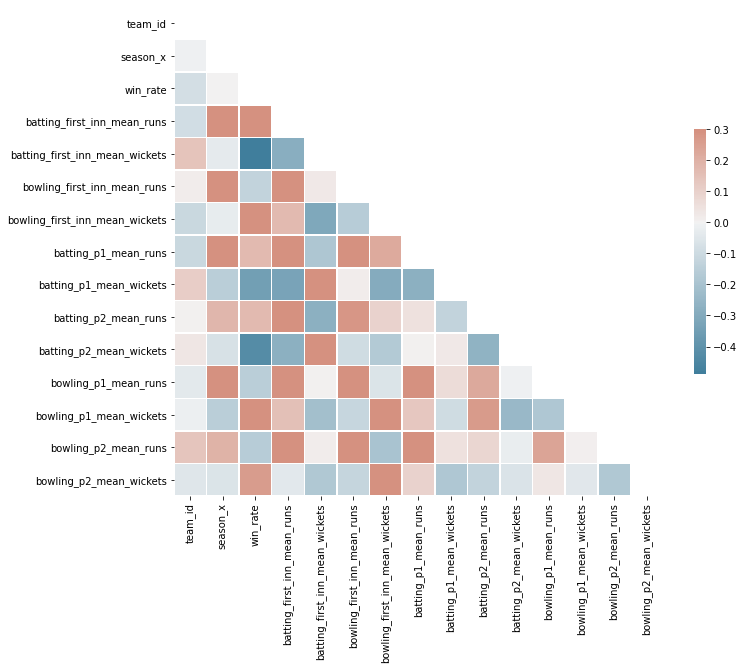

In [13]:
#Correlation Matrix
win_rate=win_lose[['team_id','season_x','win_rate']]
correl=pd.merge(left=win_rate,right=team_run_wicket_stats,left_on=['team_id','season_x'],right_on=['team_id','season_x'],how='inner')

corr = correl.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [14]:
del correl['team_id']
#del correl['season_x']
correl
cols=correl.columns
subcols=cols[1:]
title=tuple(subcols)
fig = make_subplots(rows=5, cols=3,subplot_titles=title)
j=1
k=1

for i in range(1,14):
  fig.add_trace(
      go.Scatter(x=correl.iloc[:,i], y=correl['win_rate'],name=cols[i],mode='markers'),
      row=j, col=k
  )
 # print(i,j,k)

  if(i%3==0):
    j=j+1
  if(k==3):
    k=0
  k=k+1

fig.update_layout(title='Impact of Batting & Bowling Stats on Win Rate',height=1000)
fig.show()

In [15]:
#Points Table Construction
pts_data=res_combined[['season_x','match_id','winning_team','losing_team']].copy()

pts_data['team_a']=pts_data['losing_team']
pts_data['team_b']=pts_data['winning_team']

pts_data.loc[pts_data['winning_team']<=pts_data['losing_team'],'team_a']=pts_data.loc[pts_data['winning_team']<=pts_data['losing_team'],'winning_team']
pts_data.loc[pts_data['winning_team']<=pts_data['losing_team'],'team_b']=pts_data.loc[pts_data['winning_team']<=pts_data['losing_team'],'losing_team']

pts_data['cnt_wins']=0
pts_data['cnt_match']=1

pts_data.loc[pts_data['team_a']==pts_data['winning_team'],['cnt_wins']]=1
pts_data.sort_values(by=['team_a','team_b','season_x'],inplace=True)


head2head=pts_data.groupby(['team_a','team_b','season_x']).sum().groupby(['team_a','team_b']).cumsum().reset_index()

#venue_summary=venue_summary.groupby(['team_id','venue_id','season_x']).sum().groupby(['team_id','venue_id']).cumsum().reset_index()

head2head=head2head[['team_a','team_b','season_x','cnt_wins','cnt_match']].reset_index(drop=True)
head2head=head2head.loc[head2head['team_a']!=0].reset_index(drop=True)
head2head['team_a_win_rate']=head2head['cnt_wins']/head2head['cnt_match']
head2head

,team_a,team_b,season_x,cnt_wins,cnt_match,team_a_win_rate
0,1,2,2008,1,2,0.500000
1,1,2,2009,3,7,0.428571
2,1,2,2011,4,8,0.500000
3,1,2,2012,6,10,0.600000
4,1,2,2013,8,12,0.666667
...,...,...,...,...,...,...
389,11,14,2019,10,19,0.526316
390,11,14,2020,10,21,0.476190
391,11,14,2021,10,22,0.454545
392,12,14,2016,0,2,0.000000


In [16]:
#Pts Table Position - 
pts_data_temp=pts_data[['season_x','match_id','team_a','team_b','winning_team','cnt_wins','cnt_match']].copy()
pts_data_temp

pts_data_temp.sort_values(by=['season_x','team_a','match_id'],inplace=True)
# pts_data_temp_gp['cnt_match'] = pts_data_temp_gp['cnt_match'].where(pts_data_temp_gp['cnt_match']==0,pts_data_temp_gp['cnt_match']+fac)

pts_data_temp_pivot=pts_data_temp.pivot(index=['season_x','match_id','team_a','team_b'],columns='winning_team',values='cnt_match').reset_index().fillna(0)
pts_data_temp_pivot
#pts_data_temp_pivot.sum()

cumsums=pts_data_temp_pivot.groupby(['season_x','match_id']).sum().groupby(['season_x']).cumsum().reset_index()

cumsums=cumsums.iloc[:,-12:].reset_index(drop=True)

cols_select=pts_data_temp_pivot[['season_x','match_id','team_a','team_b']].reset_index(drop=True)
cumsums

team_match_state=pd.concat([cumsums,cols_select],axis=1)
# # team_match_state.to_csv('chk.csv')
# # from google.colab import files
# # #files.download('chk.csv')
team_match_state['a_wins']=0
team_match_state['b_wins']=0

team_match_state.columns=['t1','t2','t3','t5','t6','t7','t8','t9','t10','t11','t12','t14','season_x','match_id','team_a','team_b','a_wins','b_wins']
team_match_state=team_match_state.loc[team_match_state['team_a']!=0]
team_match_state=team_match_state.loc[team_match_state['team_b']!=0]
team_match_state=team_match_state.reset_index()
team_match_state
for i in range(team_match_state.shape[0]):
  a=team_match_state.loc[i,'team_a']
  b=team_match_state.loc[i,'team_b']
 # print(i)
  team_match_state.loc[i,'a_wins']=team_match_state.loc[i,'t'+str(a)]
  team_match_state.loc[i,'b_wins']=team_match_state.loc[i,'t'+str(b)]
  #if (i<10):
   #  print(i,a,b,team_match_state.iloc[i,b])
  
team_match_state=team_match_state[['season_x','match_id','team_a','team_b','a_wins','b_wins']]
#Changing season column header so as to not match with previous season but current season column
team_match_state.columns=['season','match_id','team_a','team_b','a_wins_running_season','b_wins_running_season']
#team_match_state.to_csv('chk.csv')
#files.download('chk.csv')
# pts_data_temp_gp=pts_data_temp.groupby(['season_x','team_a','match_id']).sum().groupby(['season_x','team_a']).cumsum().reset_index()
# #weird
# pts_data_temp_gp['cnt_wins'] = pts_data_temp_gp['cnt_wins'].where(pts_data_temp_gp['cnt_wins']==0,pts_data_temp_gp['cnt_wins']+fac)

fac=-1
team_match_state['a_wins_running_season']=team_match_state['a_wins_running_season'].where(team_match_state['a_wins_running_season']==0,team_match_state['a_wins_running_season']+fac)
team_match_state['b_wins_running_season']=team_match_state['b_wins_running_season'].where(team_match_state['b_wins_running_season']==0,team_match_state['b_wins_running_season']+fac)

team_match_state


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,season,match_id,team_a,team_b,a_wins_running_season,b_wins_running_season
0,2008,335982,8,14,0.0,0.0
1,2008,335983,1,6,0.0,0.0
2,2008,335984,3,11,0.0,0.0
3,2008,335985,9,14,0.0,0.0
4,2008,335986,2,8,0.0,1.0
...,...,...,...,...,...,...
821,2021,1254079,3,14,2.0,4.0
822,2021,1254080,1,2,4.0,0.0
823,2021,1254081,9,11,2.0,1.0
824,2021,1254082,3,8,3.0,1.0


In [17]:
pltdata=pd.merge(win_lose_cum,team_mapping,on=['team_id'],how='inner')
pltdata=pltdata.loc[(pltdata['season_x']>=2010)]
fig=px.line(data_frame=pltdata,x='season_x',y='win_rate',color='team_name',title='Cumulative Win Rate for IPL Teams over the years')
fig.show()

pltdata=pd.merge(win_lose,team_mapping,on=['team_id'],how='inner')
pltdata=pltdata.loc[(pltdata['season_x']>=2010)]
fig1=px.line(data_frame=pltdata,x='season_x',y='win_rate',color='team_name',title='Individual Win Rate for IPL Teams over the years')
fig1.show()


In [18]:
win_lose['rolling_win_rate_3']=win_lose.groupby('team_id')['win_rate'].transform(lambda s: s.rolling(2, min_periods=1).mean())
win_lose

,season_x,team_id,wins,loss,win_rate,rolling_win_rate_3
8,2009,0,2,2,0.500000,0.500000
36,2013,0,2,2,0.500000,0.500000
46,2014,0,1,1,0.500000,0.500000
55,2015,0,1,1,0.500000,0.500000
72,2017,0,1,1,0.500000,0.500000
...,...,...,...,...,...,...
80,2017,14,3,10,0.230769,0.396635
88,2018,14,6,8,0.428571,0.329670
97,2019,14,6,8,0.428571,0.428571
106,2020,14,6,8,0.428571,0.428571


In [19]:
venue_win=res_combined.groupby(['venue_x','season_x','winning_team']).agg({'batting_team_id_x':'count'}).reset_index()
venue_win=venue_win.rename(columns={'venue_x':'venue','winning_team':'team_id','batting_team_id_x':'wins'})

venue_loss=res_combined.groupby(['venue_x','season_x','losing_team']).agg({'batting_team_id_x':'count'}).reset_index()
venue_loss=venue_loss.rename(columns={'venue_x':'venue','losing_team':'team_id','batting_team_id_x':'loss'})

venue_summary=pd.merge(left=venue_win,right=venue_loss,left_on=['venue','season_x','team_id'],right_on=['venue','season_x','team_id'],how='outer')
venue_summary=pd.merge(venue_summary,venue_mapping,on=['venue'],how='inner')
venue_summary

venue_summary.sort_values(by=['team_id','venue_id','season_x'],inplace=True)
venue_summary=venue_summary.groupby(['team_id','venue_id','season_x']).sum().groupby(['team_id','venue_id']).cumsum().reset_index()

add=venue_summary.loc[venue_summary['season_x']==2019]
add['season_x']=2020

venue_summary=venue_summary.append(add,ignore_index=True)
del venue_summary['home_team']

# venue_summary=pd.merge(venue_summary,venue_mapping,on=['venue_id'],how='inner')
# venue_summary
# del venue_summary['venue']
venue_summary['total_played']=venue_summary['wins']+venue_summary['loss']
venue_summary['ground_win_rate']=venue_summary['wins']/venue_summary['total_played']
#del venue_summary['wins']
#del venue_summary['loss']
venue_summary
# from google.colab import files
# venue_summary.to_csv('venue_summary.csv')
#files.download('venue_summary.csv')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,team_id,venue_id,season_x,wins,loss,total_played,ground_win_rate
0,0,1.0,2019,1.0,1.0,2.0,0.500000
1,0,8.0,2020,3.0,3.0,6.0,0.500000
2,0,16.0,2013,1.0,1.0,2.0,0.500000
3,0,17.0,2009,1.0,1.0,2.0,0.500000
4,0,17.0,2021,2.0,2.0,4.0,0.500000
...,...,...,...,...,...,...,...
956,14,17.0,2020,2.0,7.0,9.0,0.222222
957,14,23.0,2020,4.0,3.0,7.0,0.571429
958,14,24.0,2020,1.0,8.0,9.0,0.111111
959,14,26.0,2020,3.0,4.0,7.0,0.428571


In [20]:
#Venue Data
venue_summary_2020=venue_summary.loc[venue_summary['season_x']==2020]
venue_summary_2020

venue_summary_2020=pd.merge(venue_summary_2020,venue_mapping,on=['venue_id'],how='left')
venue_summary_2020['home_flag']='away'
venue_summary_2020.loc[venue_summary_2020['team_id']==venue_summary_2020['home_team'],'home_flag']='home'
venue_summary_2020
venue_summary_2020=venue_summary_2020.drop_duplicates(subset=['team_id','venue_id'])

venue_summary_2020=venue_summary_2020.groupby(['team_id','home_flag']).agg({'wins':'sum','loss':'sum'}).reset_index()

pltdata=pd.merge(venue_summary_2020,team_mapping,on=['team_id'],how='inner')
pltdata['win_rate']=pltdata['wins']/(pltdata['wins']+pltdata['loss'])

fig = px.bar(pltdata, x='team_name', y='win_rate',color='home_flag',barmode='group',title='Home/Away Win records by IPL Teams')
fig.show()


In [21]:
#Distribution of win rate by venues
from plotly.subplots import make_subplots

pltdata=venue_summary.loc[(venue_summary['season_x']==2020)&(venue_summary['team_id']!=0)&(venue_summary['total_played']>=2)]

pltdata=pd.merge(pltdata,team_mapping,on=['team_id'],how='inner')

cols=pltdata.team_id.unique()
fig=go.Figure()
for i in range(8):
  team_id=cols[i]
  df=pltdata.loc[pltdata['team_id']==team_id]
  fig =fig.add_trace(go.Violin(y=df['ground_win_rate'],x=df['team_name'],box_visible=True, meanline_visible=True,showlegend=False))


fig.update_layout(title='Distribution of Win Rate of IPL Teams Across Different Grounds(min 2 matches played)')
fig.show()

In [22]:
#Making predictions for the 2021 season

#Read schedule dataset
ptr=1254058
tot_played=all_matches.match_id.max()
match_id=pd.Series(range(ptr,ptr+56))

ipl_timetable=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/IPL-Prediction-Engine/main/IPL2021.csv')
ipl_timetable=ipl_timetable[['home_team','away_team','venue_id']]
ipl_timetable['home_team']=ipl_timetable['home_team'].str.strip()
ipl_timetable['away_team']=ipl_timetable['away_team'].str.strip()
ipl_timetable['ID']=pd.Series(range(1,57))
ipl_timetable

ipl_timetable_a=pd.merge(left=ipl_timetable,right=team_mapping,left_on='home_team',right_on='team_name',how='inner')
ipl_timetable_a=ipl_timetable_a.rename(columns={'team_id':'team_id_a'})
ipl_timetable_b=pd.merge(left=ipl_timetable_a,right=team_mapping,left_on='away_team',right_on='team_name',how='inner')
ipl_timetable_b=ipl_timetable_b.rename(columns={'team_id':'team_id_b'})
ipl_timetable_b
ipl_timetable_b['team_a']=ipl_timetable_b['team_id_a']
ipl_timetable_b['team_b']=ipl_timetable_b['team_id_b']

ipl_timetable_b.loc[ipl_timetable_b['team_id_a']>ipl_timetable_b['team_id_b'],'team_a']=ipl_timetable_b.loc[ipl_timetable_b['team_id_a']>ipl_timetable_b['team_id_b'],'team_id_b']
ipl_timetable_b.loc[ipl_timetable_b['team_id_a']>ipl_timetable_b['team_id_b'],'team_b']=ipl_timetable_b.loc[ipl_timetable_b['team_id_a']>ipl_timetable_b['team_id_b'],'team_id_a']

ipl_timetable_b=ipl_timetable_b[['ID','team_a','team_b','venue_id']].sort_values(by='ID')
ipl_timetable_b['season']=2021
ipl_timetable_b['season_x']=2020
ipl_timetable_b=ipl_timetable_b.rename(columns={'ID':'match_id'})

ipl_timetable_b=pd.merge(left=ipl_timetable_b,right=venue_mapping,left_on='venue_id',right_on='venue_id',how='inner')
ipl_timetable_b=ipl_timetable_b.drop_duplicates(subset=['match_id','venue_id'])
ipl_timetable_b=ipl_timetable_b[['match_id','season','venue','venue_id','season_x','team_a','team_b']]
ipl_timetable_b

ipl_timetable_b=ipl_timetable_b.sort_values(by='match_id')
ipl_timetable_b=ipl_timetable_b.reset_index(drop=True)

ipl_timetable_b['match_id']=match_id
ipl_timetable_b
ipl_timetable_b=ipl_timetable_b.loc[ipl_timetable_b['match_id']>tot_played].reset_index(drop=True)
ipl_timetable_b

,match_id,season,venue,venue_id,season_x,team_a,team_b
0,1254084,2021,Arun Jaitley Stadium,1,2020,1,9
1,1254085,2021,Arun Jaitley Stadium,1,2020,2,11
2,1254086,2021,"Narendra Modi Stadium, Ahmedabad",35,2020,3,6
3,1254087,2021,"Narendra Modi Stadium, Ahmedabad",35,2020,8,14
4,1254088,2021,Arun Jaitley Stadium,1,2020,2,9
5,1254089,2021,Arun Jaitley Stadium,1,2020,1,11
6,1254090,2021,"Narendra Modi Stadium, Ahmedabad",35,2020,6,14
7,1254091,2021,Arun Jaitley Stadium,1,2020,1,2
8,1254092,2021,"Narendra Modi Stadium, Ahmedabad",35,2020,3,8
9,1254093,2021,Arun Jaitley Stadium,1,2020,9,11


In [23]:

#match_data_stats_b.loc[match_data_stats_b['match_id']==1254059]

#team_run_wicket_stats.loc[team_run_wicket_stats['team_id']==3]

#venue_mapping


In [24]:
#Prepare the dataset for prediction

subset_data=all_matches[['match_id','season','venue','batting_team_id','bowling_team_id']]
subset_data=subset_data.drop_duplicates()
match_data=subset_data.drop_duplicates(subset=['match_id','season','venue']).reset_index(drop=True)
match_data['season_x']=match_data['season']-1

match_data['team_a']=match_data['batting_team_id']
match_data['team_b']=match_data['bowling_team_id']

#Assign team ids in a way that team is always the lower id and team b the higher one
match_data.loc[match_data['batting_team_id']>=match_data['bowling_team_id'],'team_a']=match_data.loc[match_data['batting_team_id']>=match_data['bowling_team_id'],'bowling_team_id']
match_data.loc[match_data['batting_team_id']>=match_data['bowling_team_id'],'team_b']=match_data.loc[match_data['batting_team_id']>=match_data['bowling_team_id'],'batting_team_id']

match_data=match_data[['match_id','season','venue','season_x','team_a','team_b']]
ipl_timetable_b=ipl_timetable_b[['match_id','season','venue','season_x','team_a','team_b']]
#match_data

#concat match_data and upcoming matches
match_data=pd.concat([match_data,ipl_timetable_b],axis=0,ignore_index=True)
#match_data

# #All dataframes that we need
win_lose_roll=win_lose[['team_id','season_x','rolling_win_rate_3']]
winners=res_combined[['match_id','winning_team']]

match_data_win_a=pd.merge(left=match_data,right=win_lose_roll,left_on=['team_a','season_x'],right_on=['team_id','season_x'],how='inner')
match_data_win_b=pd.merge(left=match_data_win_a,right=win_lose_roll,left_on=['team_b','season_x'],right_on=['team_id','season_x'],how='inner')

match_data_stats_a=pd.merge(left=match_data_win_b,right=team_run_wicket_stats,left_on=['team_a','season_x'],right_on=['team_id','season_x'],how='inner')
match_data_stats_b=pd.merge(left=match_data_stats_a,right=team_run_wicket_stats,left_on=['team_b','season_x'],right_on=['team_id','season_x'],how='inner')
match_data_stats_b

winners=res_combined[['match_id','winning_team']]
match_data_stats_b=pd.merge(match_data_stats_b,winners,how='left')
match_data_stats_b

match_data_stats_b['result']=0
match_data_stats_b.loc[match_data_stats_b['team_a']==match_data_stats_b['winning_team'],'result']=1

match_data_stats_b=pd.merge(left=match_data_stats_b,right=venue_mapping,left_on='venue',right_on='venue',how='inner')
match_data_stats_b


match_data_stats_b=pd.merge(left=match_data_stats_b,right=venue_summary,left_on=['team_a','season_x','venue_id'],right_on=['team_id','season_x','venue_id'],how='left')
match_data_stats_b

match_data_stats_b=pd.merge(left=match_data_stats_b,right=venue_summary,left_on=['team_b','season_x','venue_id'],right_on=['team_id','season_x','venue_id'],how='left')
match_data_stats_b

match_data_stats_b=match_data_stats_b.fillna(0)
match_data_stats_b=match_data_stats_b.loc[match_data_stats_b['season']>=2010]

# #Home Away flags
match_data_stats_b['home']=-1

match_data_stats_b.loc[match_data_stats_b['home_team']==match_data_stats_b['team_a'],'home']=1
match_data_stats_b.loc[match_data_stats_b['home_team']==-1,'home']=0
match_data_stats_b

# #Head2Head
match_data_stats_b=pd.merge(left=match_data_stats_b,right=head2head,left_on=['team_a','team_b','season_x'],right_on=['team_a','team_b','season_x'],how='inner')

# #Running season Stats
match_data_stats_b=pd.merge(left=match_data_stats_b,right=team_match_state,left_on=['season','match_id','team_a','team_b'],right_on=['season','match_id','team_a','team_b'],how='left')

# # #Diff
match_data_stats_b['season_win_diff']=match_data_stats_b['a_wins_running_season']-match_data_stats_b['b_wins_running_season']

match_data_stats_b['win_rate_diff']=match_data_stats_b['rolling_win_rate_3_x']-match_data_stats_b['rolling_win_rate_3_y']
match_data_stats_b['batting_p1_runs_diff']=match_data_stats_b['batting_p1_mean_runs_x']-match_data_stats_b['batting_p1_mean_runs_y']
match_data_stats_b['batting_p2_runs_diff']=match_data_stats_b['batting_p2_mean_runs_x']-match_data_stats_b['batting_p2_mean_runs_y']
match_data_stats_b['batting_p1_wkts_diff']=match_data_stats_b['batting_p1_mean_wickets_x']-match_data_stats_b['batting_p1_mean_wickets_x']
match_data_stats_b['batting_p2_wkts_diff']=match_data_stats_b['batting_p2_mean_wickets_x']-match_data_stats_b['batting_p2_mean_wickets_y']

match_data_stats_b['bowling_p1_runs_diff']=match_data_stats_b['bowling_p1_mean_runs_x']-match_data_stats_b['bowling_p1_mean_runs_y']
match_data_stats_b['bowling_p2_runs_diff']=match_data_stats_b['bowling_p2_mean_runs_x']-match_data_stats_b['bowling_p2_mean_runs_y']
match_data_stats_b['bowling_p1_wkts_diff']=match_data_stats_b['bowling_p2_mean_runs_x']-match_data_stats_b['bowling_p2_mean_runs_y']
match_data_stats_b['bowling_p2_wkts_diff']=match_data_stats_b['bowling_p1_mean_wickets_x']-match_data_stats_b['bowling_p1_mean_wickets_y']

match_data_stats_b['batting_inn_runs_diff']=match_data_stats_b['batting_first_inn_mean_runs_x']-match_data_stats_b['batting_first_inn_mean_runs_y']
match_data_stats_b['bowling_inn_runs_diff']=match_data_stats_b['bowling_first_inn_mean_runs_x']-match_data_stats_b['bowling_first_inn_mean_runs_y']

match_data_stats_b['bowling_inn_wkts_diff']=match_data_stats_b['bowling_first_inn_mean_wickets_x']-match_data_stats_b['bowling_first_inn_mean_wickets_y']


match_data_stats_b['ground_win_rate_diff']=match_data_stats_b['ground_win_rate_x']-match_data_stats_b['ground_win_rate_y']
match_data_stats_b=match_data_stats_b.fillna(0)


In [25]:
match_data_stats_b.sort_values(by='match_id')
match_data_stats_b.loc[match_data_stats_b.season==2021].sort_values(by='match_id')

,match_id,season,venue,season_x,team_a,team_b,team_id_x,rolling_win_rate_3_x,team_id_y,rolling_win_rate_3_y,batting_first_inn_mean_runs_x,batting_first_inn_mean_wickets_x,bowling_first_inn_mean_runs_x,bowling_first_inn_mean_wickets_x,batting_p1_mean_runs_x,batting_p1_mean_wickets_x,batting_p2_mean_runs_x,batting_p2_mean_wickets_x,bowling_p1_mean_runs_x,bowling_p1_mean_wickets_x,bowling_p2_mean_runs_x,bowling_p2_mean_wickets_x,team_id_x,batting_first_inn_mean_runs_y,batting_first_inn_mean_wickets_y,bowling_first_inn_mean_runs_y,bowling_first_inn_mean_wickets_y,batting_p1_mean_runs_y,batting_p1_mean_wickets_y,batting_p2_mean_runs_y,batting_p2_mean_wickets_y,bowling_p1_mean_runs_y,bowling_p1_mean_wickets_y,bowling_p2_mean_runs_y,bowling_p2_mean_wickets_y,team_id_y,winning_team,result,venue_id,home_team,team_id_x,wins_x,loss_x,total_played_x,ground_win_rate_x,team_id_y,wins_y,loss_y,total_played_y,ground_win_rate_y,home,cnt_wins,cnt_match,team_a_win_rate,a_wins_running_season,b_wins_running_season,season_win_diff,win_rate_diff,batting_p1_runs_diff,batting_p2_runs_diff,batting_p1_wkts_diff,batting_p2_wkts_diff,bowling_p1_runs_diff,bowling_p2_runs_diff,bowling_p1_wkts_diff,bowling_p2_wkts_diff,batting_inn_runs_diff,bowling_inn_runs_diff,bowling_inn_wkts_diff,ground_win_rate_diff
331,1254058,2021,"MA Chidambaram Stadium, Chepauk, Chennai",2020,9,14,9,0.726190,14,0.428571,166.375000,4.812500,150.562500,6.250000,48.687500,1.437500,45.785714,1.428571,42.187500,2.062500,32.625000,1.562500,9,144.600000,5.266667,147.266667,5.466667,42.666667,1.066667,37.214286,1.785714,43.466667,1.400000,36.428571,1.571429,14,14.0,0,17.0,1.0,9.0,5.0,3.0,8.0,0.625000,14.0,2.0,7.0,9.0,0.222222,-1,17,26,0.653846,0.0,0.0,0.0,0.297619,6.020833,8.571429,0.0,-0.357143,-1.279167,-3.803571,-3.803571,0.662500,21.775000,3.295833,0.783333,0.402778
345,1254059,2021,"Wankhede Stadium, Mumbai",2020,1,3,1,0.508403,3,0.550000,149.642857,4.785714,156.214286,5.357143,40.071429,1.500000,38.142857,1.428571,42.642857,1.071429,38.461538,2.230769,1,156.352941,6.176471,158.235294,6.117647,42.352941,1.705882,35.882353,2.000000,45.117647,1.588235,35.312500,2.125000,3,3.0,0,34.0,9.0,1.0,7.0,7.0,14.0,0.500000,3.0,3.0,6.0,9.0,0.333333,-1,15,23,0.652174,0.0,0.0,0.0,-0.041597,-2.281513,2.260504,0.0,-0.571429,-2.474790,3.149038,3.149038,-0.516807,-6.710084,-2.021008,-0.760504,0.166667
101,1254060,2021,"MA Chidambaram Stadium, Chepauk, Chennai",2020,2,8,2,0.480952,8,0.461538,149.812500,5.437500,146.687500,6.187500,47.750000,1.062500,31.333333,2.333333,43.187500,1.625000,37.250000,1.812500,2,151.714286,6.857143,151.428571,5.000000,40.571429,1.642857,39.000000,1.857143,44.428571,1.071429,34.692308,1.538462,8,8.0,0,17.0,1.0,2.0,2.0,5.0,7.0,0.285714,8.0,2.0,7.0,9.0,0.222222,-1,10,27,0.370370,0.0,0.0,0.0,0.019414,7.178571,-7.666667,0.0,0.476190,-1.241071,2.557692,2.557692,0.553571,-1.901786,-4.741071,1.187500,0.063492
91,1254061,2021,"Wankhede Stadium, Mumbai",2020,6,11,6,0.422619,11,0.392857,161.714286,5.428571,160.285714,5.857143,47.928571,1.285714,34.785714,1.714286,47.285714,1.571429,38.357143,2.214286,6,156.928571,6.428571,168.571429,4.642857,44.357143,2.071429,34.928571,1.642857,47.000000,1.214286,44.071429,1.214286,11,6.0,1,34.0,9.0,6.0,5.0,6.0,11.0,0.454545,11.0,4.0,4.0,8.0,0.500000,-1,8,20,0.400000,0.0,0.0,0.0,0.029762,3.571429,-0.142857,0.0,0.071429,0.285714,-5.714286,-5.714286,0.357143,4.785714,-8.285714,1.214286,-0.045455
109,1254062,2021,"MA Chidambaram Stadium, Chepauk, Chennai",2020,8,9,8,0.461538,9,0.726190,151.714286,6.857143,151.428571,5.000000,40.571429,1.642857,39.000000,1.857143,44.428571,1.071429,34.692308,1.538462,8,166.375000,4.812500,150.562500,6.250000,48.687500,1.437500,45.785714,1.428571,42.187500,2.062500,32.625000,1.562500,9,9.0,0,17.0,1.0,8.0,2.0,7.0,9.0,0.222222,9.0,5.0,3.0,8.0,0.625000,-1,6,27,0.222222,0.0,0.0,0.0,-0.264652,-8.116071,-6.785714,0.0,0.428571,2.241071,2.067308,2.067308,-0.991071,-14.660714,0.866071,-1.250000,-0.402778
335,1254063,2021,"MA Chidambar

In [26]:
from google.colab import files
match_data_stats_b.shape
match_data_stats_b.to_csv('chk.csv')
#files.download('chk.csv')

#match_data_stats_b.loc[match_data_stats_b['season']==2021].fillna(0)



In [27]:
#model_data=match_data_stats_b.loc[match_data_stats_b['match_id']<=all_matches.match_id.max()]

X=match_data_stats_b.copy()
Y=match_data_stats_b['result']
del X['winning_team']
del X['match_id']
del X['venue']

X=X[['season',
      'win_rate_diff','team_a_win_rate','season_win_diff',
    # 'batting_p1_runs_diff',
    # 'batting_p2_runs_diff',
     
    # 'bowling_p1_wkts_diff','bowling_p2_wkts_diff',
     'bowling_p1_runs_diff','bowling_p2_runs_diff',

  #   'batting_p1_wkts_diff','batting_p2_wkts_diff',
     'batting_inn_runs_diff','bowling_inn_runs_diff',
     'ground_win_rate_diff',#'bowling_inn_wkts_diff',
      #  'batting_first_inn_mean_runs_x', 'batting_first_inn_mean_wickets_x',
      #  'bowling_first_inn_mean_runs_x', 'bowling_first_inn_mean_wickets_x',
      #  'batting_p1_mean_runs_x', 'batting_p1_mean_wickets_x',
      #  'batting_p2_mean_runs_x', 'batting_p2_mean_wickets_x',
      #  'bowling_p1_mean_runs_x', 'bowling_p1_mean_wickets_x',
      #  'bowling_p2_mean_runs_x', 'bowling_p2_mean_wickets_x',
      #  'batting_first_inn_mean_runs_y', 'batting_first_inn_mean_wickets_y',
      #  'bowling_first_inn_mean_runs_y', 'bowling_first_inn_mean_wickets_y',
      #  'batting_p1_mean_runs_y', 'batting_p1_mean_wickets_y',
      #  'batting_p2_mean_runs_y', 'batting_p2_mean_wickets_y',
      #  'bowling_p1_mean_runs_y', 'bowling_p1_mean_wickets_y',
      #  'bowling_p2_mean_runs_y', 'bowling_p2_mean_wickets_y',
       'result', 
     #'home'
     ]]

X_train=X.loc[X['season']<=2019]
X_test=X.loc[X['season']==2020]
Y_train=X_train['result']
Y_test=X_test['result']

del X_train['result']
del X_test['result']
del X_train['season']
del X_test['season']

Model Accuracy
0.6666666666666666


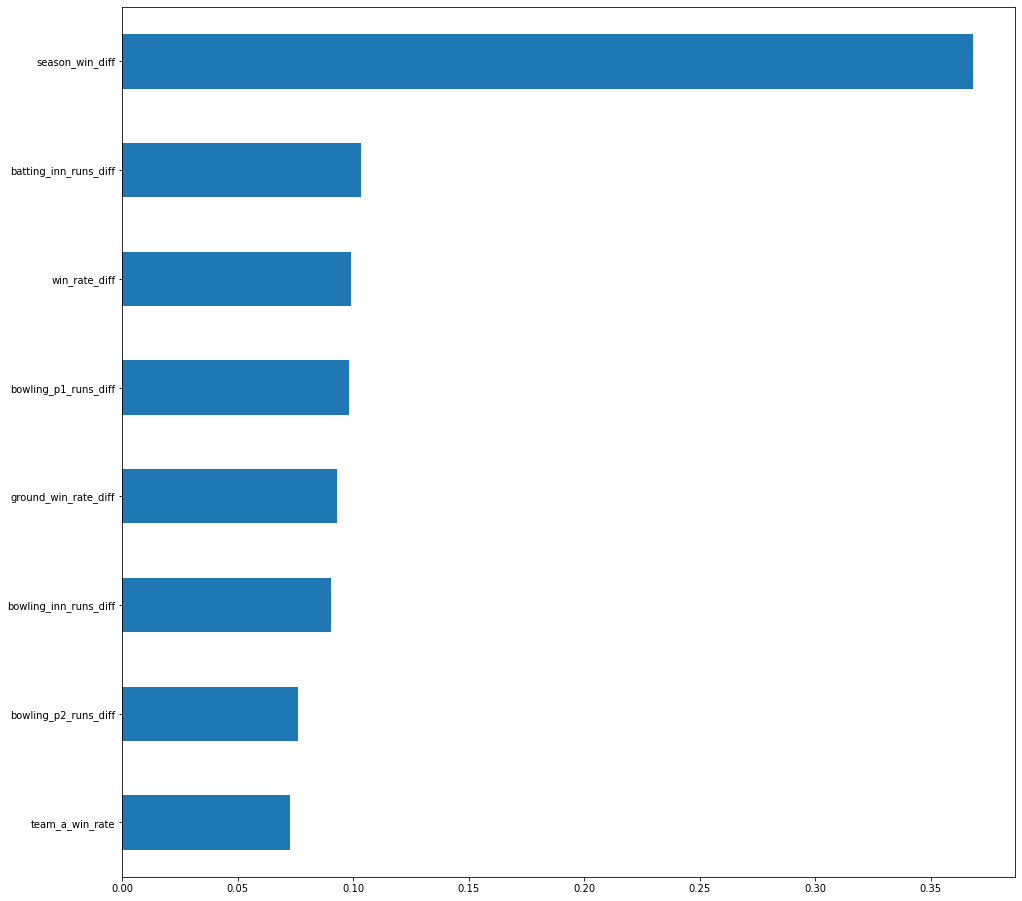

In [28]:
model_rf = RandomForestClassifier(n_estimators=100,max_depth=5, random_state=0,min_samples_split=3)
#class_weight='balanced_subsample'
model_rf.fit(X_train,Y_train)#Fitting the model 
#Generating predictions from Random Fores Models
pred_rf=model_rf.predict(X_test)
pred_rf_proba=model_rf.predict_proba(X_test)

feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance

print('Model Accuracy')
print(model_rf.score(X_test,Y_test))

2016
0.71875
20
2017
0.711864406779661
26
2018
0.6129032258064516
16
2019
0.65
36
2020
0.6666666666666666
29
2021
0.8035714285714286
12


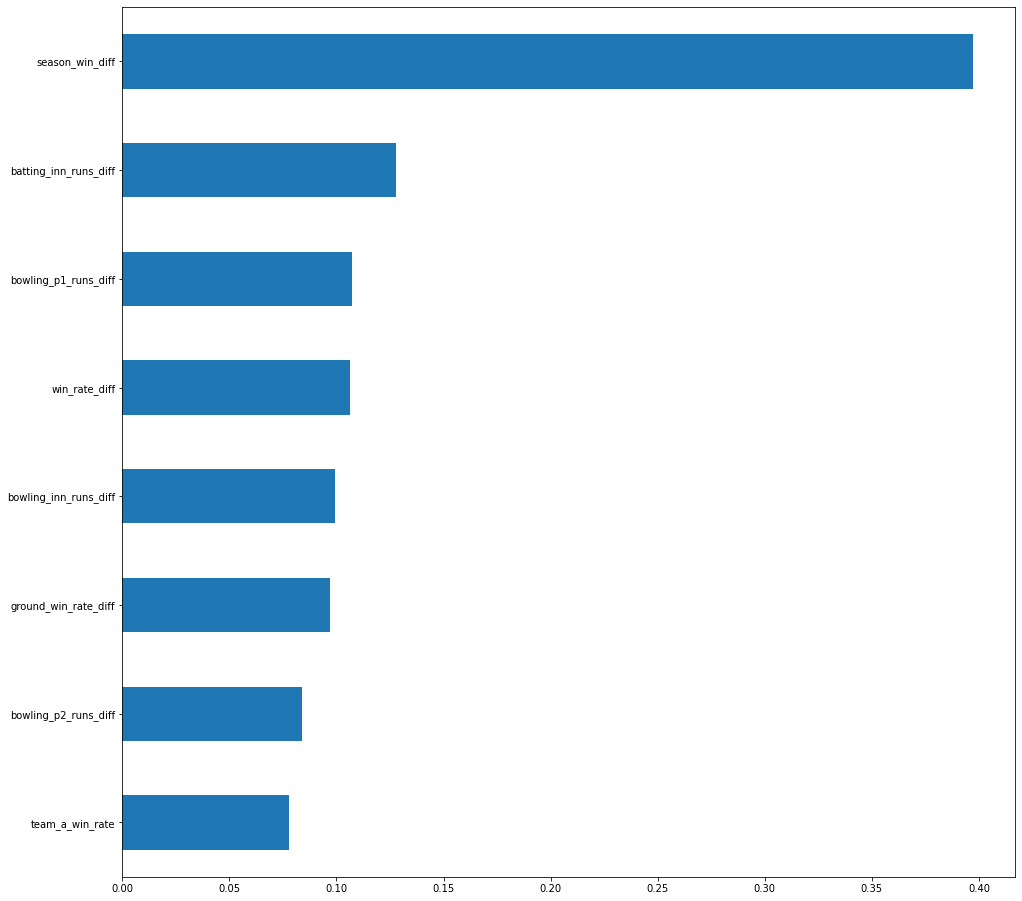

In [29]:

season_list=[]
accuracy_list=[]
for i in range(2015,2021):
  X_train=X.loc[X['season']<=i]
  X_test=X.loc[X['season']==(i+1)]
  Y_train=X_train['result']
  Y_test=X_test['result']

  del X_train['result']
  del X_test['result']
  del X_train['season']
  del X_test['season']

  model_rf = RandomForestClassifier(n_estimators=100,max_depth=5, random_state=0,min_samples_split=3)
#class_weight='balanced_subsample'
  model_rf.fit(X_train,Y_train)#Fitting the model 
#Generating predictions from Random Fores Models
  pred_rf=model_rf.predict(X_test)
  pred_rf_proba=model_rf.predict_proba(X_test)

  feat_importances = pd.Series(model_rf.feature_importances_, index=X_train.columns)
  feat_importances=feat_importances.sort_values()
  feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance
  season_list.append(i+1)
  accuracy_list.append(model_rf.score(X_test,Y_test))
#print('Model Accuracy')
  print(i+1)
  print(model_rf.score(X_test,Y_test))
  print(pred_rf.sum())



In [30]:
train_accuracy=pd.DataFrame({'season':season_list,'accuracy':accuracy_list})
px.bar(train_accuracy,x=train_accuracy['season'],y=train_accuracy['accuracy'],title='Accuracy of Model for Different IPL Seasons')

In [31]:
ipl_timetable=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/IPL-Prediction-Engine/main/IPL2021.csv')
team_mapping_new=team_mapping_new.loc[team_mapping_new['new']==1]

season_2021=match_data_stats_b.loc[match_data_stats_b['season']==2021].copy()
test=season_2021[[
      'win_rate_diff','team_a_win_rate','season_win_diff',
    # 'batting_p1_runs_diff',
    # 'batting_p2_runs_diff',
     
    # 'bowling_p1_wkts_diff','bowling_p2_wkts_diff',
     'bowling_p1_runs_diff','bowling_p2_runs_diff',
  #   'batting_p1_wkts_diff','batting_p2_wkts_diff',
     'batting_inn_runs_diff','bowling_inn_runs_diff',
     'ground_win_rate_diff',#'bowling_inn_wkts_diff',
     ]]

preds=model_rf.predict_proba(test)
preds
season_2021['pred_team_x']=preds[:,1]
season_2021['pred_team_y']=1-season_2021['pred_team_x']


season_2021=pd.merge(left=season_2021,right=team_mapping_new,left_on=['team_a'],right_on='team_id')
season_2021=pd.merge(left=season_2021,right=team_mapping_new,left_on=['team_b'],right_on='team_id')
season_2021=season_2021[['team_name_x','team_name_y','match_id','venue','pred_team_x','pred_team_y','winning_team']]
season_2021=pd.merge(left=season_2021,right=team_mapping_new,left_on=['winning_team'],right_on='team_id',how='left')

season_2021.sort_values(by='match_id',inplace=True)
season_2021



,team_name_x,team_name_y,match_id,venue,pred_team_x,pred_team_y,winning_team,team_id,team_name,new
39,Mumbai Indians,Royal Challengers Bangalore,1254058,"MA Chidambaram Stadium, Chepauk, Chennai",0.523843,0.476157,14.0,14.0,Royal Challengers Bangalore,1.0
51,Chennai Super Kings,Delhi Capitals,1254059,"Wankhede Stadium, Mumbai",0.362591,0.637409,3.0,3.0,Delhi Capitals,1.0
17,Sunrisers Hyderabad,Kolkata Knight Riders,1254060,"MA Chidambaram Stadium, Chepauk, Chennai",0.374893,0.625107,8.0,8.0,Kolkata Knight Riders,1.0
1,Punjab Kings,Rajasthan Royals,1254061,"Wankhede Stadium, Mumbai",0.399823,0.600177,6.0,6.0,Punjab Kings,1.0
23,Kolkata Knight Riders,Mumbai Indians,1254062,"MA Chidambaram Stadium, Chepauk, Chennai",0.337221,0.662779,9.0,9.0,Mumbai Indians,1.0
37,Sunrisers Hyderabad,Royal Challengers Bangalore,1254063,"MA Chidambaram Stadium, Chepauk, Chennai",0.333148,0.666852,14.0,14.0,Royal Challengers Bangalore,1.0
11,Delhi Capitals,Rajasthan Royals,1254064,"Wankhede Stadium, Mumbai",0.513514,0.486486,11.0,11.0,Rajasthan Royals,1.0
45,Chennai Super Kings,Punjab Kings,1254065,"Wankhede Stadium, Mumbai",0.400071,0.599929,1.0,1.0,Chennai Super Kings,1.0
27,Sunrisers Hyderabad,Mumbai Indians,1254066,"MA Chidambaram Stadium, Chepauk, Chennai",0.254089,0.745911,9.0,9.0,Mumbai Indians,1.0
32,Kolkata Knight Riders,Royal Challengers Bangalore,1254067,"MA Chidambaram Stadium, Chepauk, Chennai",0.304388,0.695612,14.0,14.0,Royal Challengers Bangalore,1.0


In [32]:
ipl_timetable['match_id']=pd.Series(range(1254058,1254058+56))
ipl_timetable['date'] = pd.to_datetime(ipl_timetable['date'])
ipl_timetable['date'] = ipl_timetable['date'].dt.date

ipl_timetable=ipl_timetable[['match_id','date']]
final_output=pd.merge(left=season_2021,right=ipl_timetable,left_on='match_id',right_on=match_id,how='inner')
final_output=final_output[['match_id','venue','team_name_x','team_name_y','date','pred_team_x','pred_team_y','team_name']]
final_output=final_output.rename(columns={'team_name':'winning_team'})
final_output



,match_id,venue,team_name_x,team_name_y,date,pred_team_x,pred_team_y,winning_team
0,1254058,"MA Chidambaram Stadium, Chepauk, Chennai",Mumbai Indians,Royal Challengers Bangalore,2021-09-04,0.523843,0.476157,Royal Challengers Bangalore
1,1254059,"Wankhede Stadium, Mumbai",Chennai Super Kings,Delhi Capitals,2021-10-04,0.362591,0.637409,Delhi Capitals
2,1254060,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Kolkata Knight Riders,2021-11-04,0.374893,0.625107,Kolkata Knight Riders
3,1254061,"Wankhede Stadium, Mumbai",Punjab Kings,Rajasthan Royals,2021-12-04,0.399823,0.600177,Punjab Kings
4,1254062,"MA Chidambaram Stadium, Chepauk, Chennai",Kolkata Knight Riders,Mumbai Indians,2021-04-13,0.337221,0.662779,Mumbai Indians
5,1254063,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Royal Challengers Bangalore,2021-04-14,0.333148,0.666852,Royal Challengers Bangalore
6,1254064,"Wankhede Stadium, Mumbai",Delhi Capitals,Rajasthan Royals,2021-04-15,0.513514,0.486486,Rajasthan Royals
7,1254065,"Wankhede Stadium, Mumbai",Chennai Super Kings,Punjab Kings,2021-04-16,0.400071,0.599929,Chennai Super Kings
8,1254066,"MA Chidambaram Stadium, Chepauk, Chennai",Sunrisers Hyderabad,Mumbai Indians,2021-04-17,0.254089,0.745911,Mumbai Indians
9,1254067,"MA Chidambaram Stadium, Chepauk, Chennai",Kolkata Knight Riders,Royal Challengers Bangalore,2021-04-18,0.304388,0.695612,Royal Challengers Bangalore


In [38]:
final_output.to_csv('final_output.csv')
#files.download('final_output.csv')

team_x=final_output.loc[0,'team_name_x']
team_y=final_output.loc[0,'team_name_y']
team_y.replace(" ",'%20')


'Royal%20Challengers%20Bangalore'

In [43]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(
    y=['Win Probability'],
    x=[20],
    name='MI',
    orientation='h',
))
fig.add_trace(go.Bar(
    y=['Win Probability'],
    x=[80],
    name='ECB',
    orientation='h',
))
fig.update_layout(barmode='stack')
